<a href="https://colab.research.google.com/github/MaralAminpour/ML-BME-Course-UofA-Fall-2023/blob/main/Week-3-Classification-models/3.2-Classification-models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Binary Classification Models

We will go through a series of examples creating different types of binary classification models for the same dataset. Binary classifiers predict two labels. Usually, we'll convert our labels to 0 and 1.  We will use the example of heart disease data.

In [ ]:
# Imports needed for this notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Note that if you are using Anaconda, GraphViz won't be installed by default.
# You will need to install graphviz and python-graphviz.
import graphviz

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, classification_report, roc_curve, auc
from sklearn.linear_model import Perceptron, LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier

First, let's load the data we'll need for all the examples.

In [ ]:
# This code will download the required data files from GitHub
import requests
def download_data(source, dest):
    base_url = 'https://raw.githubusercontent.com/'
    owner = 'SirTurtle'
    repo = 'ML-BME-UofA-data'
    branch = 'main'
    url = '{}/{}/{}/{}/{}'.format(base_url, owner, repo, branch, source)
    r = requests.get(url)
    f = open(dest, 'wb')
    f.write(r.content)
    f.close()

# Create the temp directory, if it doesn't already exist
import os
if not os.path.exists('temp'):
   os.makedirs('temp')

In [ ]:
# Download the data
download_data('Week-3-Classification-models/data/heart_failure_data.csv', 'temp/heart_failure_data.csv')

# Read data file into a dataframe object
df = pd.read_csv('temp/heart_failure_data.csv')

# Print the first few lines of the dataframe
df.head()

,EF,GLS,HF
0,50.922280,-19.57,0
1,54.601227,-19.00,0
2,50.000000,-21.00,0
3,50.819672,-18.74,0
4,53.191489,-19.78,0


## Data dictionary

**EF**: Ejection Fraction. A measurement of how much blood the left ventricle pumps out with each contraction. Expressed as a percent in the range 0 to 100.

**GLS**: Global Longitudinal Strain. A measurement of myocardial deformation along the longitudinal cardiac axis. Expressed as a negative percent in the range 0 to -100.

**HF**: Heart Failure class
- 0 = Healthy
- 1 = Heart failure

### Exploratory Data Analysis

Here we use the pandas library in Python to **group a DataFrame by the values** in the 'HF' column and then **count the number of occurrences** of each value in the 'HF' column.

In [ ]:
# Check balance of the output variables
df.groupby(['HF'])['HF'].count()

HF
0    60
1    60
Name: HF, dtype: int64

Our example has **an exactly equal number of samples in each class**. If we had an unbalanced dataset, we could balance it by

1. **removing some random samples** from the larger class, or by

2. **duplicating small samples from the smaller class**.

In [ ]:
# Convert to numpy
heart_failure_data = df.to_numpy()

# Create feature matrix and target vector
X = heart_failure_data[:,:2]   #all rows (:) and the first two columns (:2) of heart_failure_data
y = heart_failure_data[:,2]    #all rows (:) and only the third column (2) of heart_failure_data.


print('Feature matrix X dimensions: ', X.shape)
print('Target vector y dimensions: ', y.shape)

Feature matrix X dimensions:  (120, 2)
Target vector y dimensions:  (120,)


## Plot data

First, let's plot the data. The function takes two inputs:

- Here, X is expected to be a 2D array with two columns representing two features (EF and GLS), and

- y is expected to be a 1D array representing two classes: Healthy (0) and Heart Failure (1).


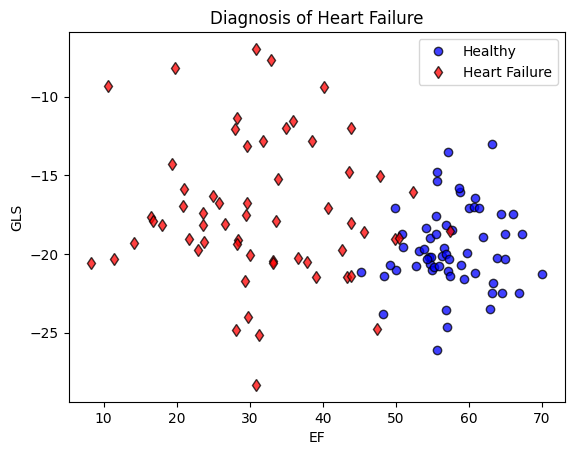

In [ ]:
# This function will plot the heart failure data
# We will plot the first feature (EF) on the x-axis and the second feature (GLS) on the y-axis
def PlotData(X, y):

    # Plot class 0 (all the data points that are classified as 'Healthy' (class 0))
    # X[y==0]: This would give you all the rows in X where y is 0. (y==0 is a mask, it is true when y==0)
    # X[y==0,0]: This gives you all the values in the first column of X for the rows where y is 0.
    # X[y==0,1]: This gives you all the values in the second column of X for the rows where y is 0.
    plt.plot(X[y==0,0], X[y==0,1], 'bo', alpha=0.75, markeredgecolor='k', label = 'Healthy')

    # Plot class 1 ()plotting all the data points that are classified as 'Heart Failure'
    plt.plot(X[y==1,0], X[y==1,1], 'rd', alpha=0.75, markeredgecolor='k', label = 'Heart Failure')

    # Annotate the plot
    plt.title('Diagnosis of Heart Failure')
    plt.xlabel('EF')
    plt.ylabel('GLS')
    plt.legend()

# Call the function to plot the dataset
PlotData(X, y)

## Standardize Data

We'll use [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) to standardize the features.

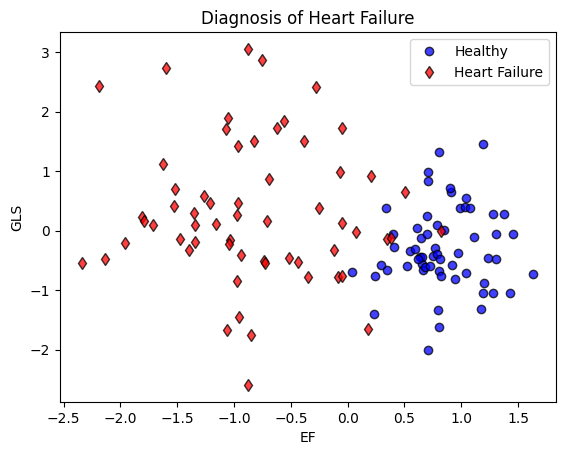

In [ ]:
# Create an object to scale the features to have zero mean and unit variance
# We don't need to do this for all models, but let's do it here to be consistent
scaler = StandardScaler()

# Create a feature matrix containing EF and GLS
X = scaler.fit_transform(X)

# Plot the scaled data using PlotData function that we defined above
PlotData(X, y)

### **Feature Scaling**

 In many machine learning algorithms, it's beneficial to have **features that are on a similar scale**. This is because algorithms, such as gradient descent, will converge faster, and models can be more accurately trained when features are standardized.

 In machine learning, it is necessary to bring all the features to a common scale. **The scaling of features ensures that a feature with a relatively higher magnitude will not govern or control the trained model.**

<img src='https://raw.githubusercontent.com/MaralAminpour/ML-BME-Course-UofA-Fall-2023/main/Week-3-Classification-models/imgs/feature_scaling.webp' width=300px>

[source](https://medium.com/nerd-for-tech/why-feature-scaling-or-standardization-is-important-in-machine-learning-aaba175b664)



---


**StandardScaler**

To help with this, we will be using the StandardScaler from the scikit-learn library to standardize our features. What standardizing does is **it transforms the features to have a mean of 0 and a standard deviation of 1**. In more simple terms, it makes our dataset's feature values more comparable to each other by bringing them onto a similar scale, which, in turn, aids in improving the performance of our machine learning model.

Utilizing StandardScaler is a common preprocessing step to ensure that all of our features are treated equally while training the model. This process **doesn't alter the shape of each feature's distribution**; **it just relocates the distribution to have a mean value of zero and scales it to have a standard deviation of one**.

When you have a moment to unwind, I highly recommend checking out this intresting article. Enjoy!

[Scale, Standardize, or Normalize with Scikit-Learn](https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02)

## Creating training and test sets

We'll create training and test sets that we'll use for each example. For these examples, we'll just split up the data samples randomly, with 60% in the training set and 40% in the test set. A more common division would be (80%,20%) but since our **dataset is small**, we'll use **more in the test set**. We'll use the [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)  function.

<font color=blue>**Importing train_test_split**</font>


Before running the code, you need to import the function from scikit-learn. You would have a line like this somewhere above in your script:

<font color=blue>**from sklearn.model_selection import train_test_split**</font>


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
# Using a fixed random_state for consistency


---

<font color=blue>**train_test_split**</font>

<font color=blue>**X, y:**</font>  These are your **feature matrix** and **label array**, respectively.

<font color=blue>X</font>  contains the data for your features, and

**<font color=blue>y</font>  contains the labels associated with each row of X**.

<font color=blue>**test_size=0.4:**</font>  

This argument specifies that 40% of the data will be used as the test set, and the remaining 60% will be used as the training set.

<font color=blue>**random_state=0:**</font>

This argument sets the random seed for the split. Using a **fixed seed** (like 0) ensures that if you run your script multiple times, **you'll get the same split each time**, which can be helpful for **debugging and comparing** different models.



---

<font color=blue>Output</font>

The <font color=blue>train_test_split</font> function returns four arrays:

<font color=blue>X_train</font>: The subset of <font color=blue>X</font> to be used for training.

<font color=blue>X_test</font>: The subset of <font color=blue>X</font> to be used for testing.

<font color=blue>y_train</font>: The subset of <font color=blue>y</font> corresponding to <font color=blue>X_train</font>.

<font color=blue>y_test</font>: The subset of <font color=blue>y</font> corresponding to <font color=blue>X_test</font>.

## Perceptron

Here, you are using the Perceptron model, **a type of linear classifier** that works well for **binary classification** problems.

### Fit the model
This code fits the [Perceptron](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html) model to the training data.

In machine learning, "fitting the model" refers to the **process of training the model using a dataset**. During this process, the model learns the underlying patterns in the data, which it later uses to make predictions on new, unseen data.

Note that the Perceptron model is the same as the [SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) function with **SGDClassifier**(loss="perceptron", eta0=1, learning_rate="constant", penalty=None).

In [ ]:
# Create and fit the model
p_model = Perceptron(max_iter=100, eta0=0.2, random_state=0)
p_model.fit(X_train, y_train)

**Elaboration on code:**

Below, we are elaborating on the different components involved in this process and the parameters you are using:

<font color=blue>**Perceptron(max_iter=100, eta0=0.2, random_state=0)**</font>

<font color=blue>**max_iter=100:**</font>

This parameter specifies the **maximum number of passes (or iterations) over the training dataset**, also known as **epochs**. In this case, it is set to 100, meaning the algorithm will go through the training dataset up to 100 times to **fine-tune the model's weights**.

<font color=blue>**eta0=0.2:**</font>  

Here, eta0 is the learning rate, a hyperparameter that determines the step size during the weight update process in each iteration. A smaller learning rate (like 0.2) means that the model will learn slowly and might require more epochs, but it can help in reaching a more accurate solution.
  
<font color=blue> **random_state=0:**</font>   

Setting a random_state ensures that the splits you generate are reproducible. Scikit-learn uses random permutations to generate the splits. The random state that you provide is used as a seed to the random number generator, ensuring that you get the same split each time you run the script.

<font color=blue> **p_model.fit(X_train, y_train)**</font>

This line of code **initiates the actual training of the Perceptron model** using the **training dataset** comprised of **X_train (feature matrix) and y_train (target vector)**.


---



### Evaluate the model

We'll perform the same basic analysis for each model. First, we'll show the **confusion matrix** for the test set. Then we'll calculate several **useful scores**. This will help to evaluate the **performance** of each model and also to assess how much **overfitting** we have. Next, we'll also generate some interesting plots for each model.

We'll use the [confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) and the [accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) function. We'll use the [recall_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html) to calculate the sensitivity specificity.

Note that in binary classification, the recall of the positive class is also known as “**sensitivity**”; the recall of the negative class is “**specificity**”.

In our example:
- Negative: HF = 0 = healthy
- Positive: HF = 1 = heart failure

An alternative is to use the [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) function. This will return the recall, precision and F1 score on all classes.



---



**A Quick Refresher on Previously Covered Material:**

A **confusion matrix** is a table that you create using (TN,TP,FN,FP) four values to understand the performance of the diagnostic test.

**Accuracy** is the proportion of the total number of predictions that were correct.

**Recall** (also known as sensitivity or true positive rate) is the proportion of actual positive cases that were identified correctly.

the **specificity** (or true negative rate) is the proportion of actual negative cases that were identified correctly.

**Sensitivity** (Recall for the positive class) would tell us how well the test identifies heart failure.

**Specificity** (Recall for the negative class) would tell us how well the test identifies healthy individuals.

So, by looking at these metrics individually and together, the doctor can get a sense of **how well the diagnostic test performs** and where it might have weaknesses. It helps to ensure that the test is trustworthy and to understand the kind of mistakes it tends to make **(whether it is more likely to misdiagnose healthy individuals or fail to identify true cases of heart failure)**.


---



**EvaluateModel function**

The EvaluateModel function you provided is designed to **evaluate a given model on both the training and test sets**.

It calculates accuracy, sensitivity (recall), and specificity, then it **prints these metrics for both datasets**. Additionally, the function visually displays the confusion matrix for the test set using a **heatmap**.

**Don't forget to include the import ones**

Ensure you have the necessary imports at the beginning of your script:

we already did it somewhere above:

from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

**Seaborn library in Python.**

Seaborn is a powerful data visualization library based on Matplotlib. It provides a high-level interface for creating attractive statistical graphics.


In [ ]:
def EvaluateModel(model, X_train, X_test, y_train, y_test):

    # Calculate and print metrics for the training set

    #predict the labels for the training set (X_train) using
    #the trained model and store the predictions in y_train_pred.
    y_train_pred = model.predict(X_train)
    #calculates the accuracy of the model on the training set using the
    #accuracy_score function. Accuracy measures the proportion of correct
    #predictions out of all predictions.
    train_accuracy = accuracy_score(y_train, y_train_pred)
    #calculates the sensitivity (or recall) for the model on the training set.
    #Sensitivity measures the proportion of actual positive cases
    #(labelled as 1 in this context) that were correctly identified by the model.
    train_sensitivity = recall_score(y_train, y_train_pred, pos_label=1)
    #Specificity measures the proportion of actual negative cases
    #(labelled as 0 in this context) that were correctly identified by the model.
    #It's calculated similarly to sensitivity, but by setting pos_label=0.
    train_specificity = recall_score(y_train, y_train_pred, pos_label=0)
    #This line prints the calculated metrics with a precision of two decimal places.
    print('Training set: Accuracy = {:0.2f} Sensitivity = {:0.2f} Specificity = {:0.2f}'.format(train_accuracy, train_sensitivity, train_specificity))

    # Calculate and print metrics for the test set
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_sensitivity = recall_score(y_test, y_test_pred, pos_label=1)
    test_specificity = recall_score(y_test, y_test_pred, pos_label=0)
    print('Test set: Accuracy = {:0.2f} Sensitivity = {:0.2f} Specificity = {:0.2f}'.format(test_accuracy, test_sensitivity, test_specificity))

    # Display the confusion matrix for the test set

    #This line uses the confusion_matrix function to generate the confusion matrix
    #for the true labels (y_test) and the predicted labels (y_test_pred).
    #The result is stored in the cm variable.
    cm = confusion_matrix(y_test, y_test_pred)
    #This line uses Seaborn's heatmap function to visualize the confusion matrix.
    #The annot=True argument ensures that the individual values of the confusion
    #matrix are annotated (i.e., displayed) on the heatmap.
    sns.heatmap(cm, annot=True)
    #This line sets the size of the figure to 2x2 inches. gcf() stands
    #for "get current figure", and set_size_inches sets the size of that figure.
    plt.gcf().set_size_inches(2, 2)
    plt.show()

EvaluateModel(p_model, X_train, X_test, y_train, y_test)

To run this code, **ensure you have the necessary libraries imported** which we did it in the beginning of the class.

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


**What Do These Numbers Indicate?**

We have better sensitivity and worse specificity.

1. Our model is better at correctly **predicting that patients with heart disease have heart disease**, but is

2. worse at correctly predicting that **patients without heart disease don't have heart disease**.

In [ ]:
# This is an alternate function for evaluating the model results using the classification_report function
def EvaluateModelClassificationReport(model, X_train, X_test, y_train, y_test):

    # Calculate and print classification report for the training set
    y_train_pred = model.predict(X_train)
    print('Classification report for training set:')
    print(classification_report(y_train, y_train_pred))

    # Calculate and print classification report for the test set
    y_test_pred = model.predict(X_test)
    print('Classification report for test set:')
    print(classification_report(y_test, y_test_pred))

    # Display the confusion matrix for the test set
    cm = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(cm, annot=True)
    plt.gcf().set_size_inches(2, 2)
    plt.show()

EvaluateModelClassificationReport(p_model, X_train, X_test, y_train, y_test)

### Plot the model

Let's also visualize the **decision boundary** itself. This specific visualization **only works because we have two features**. (In general, the decision boundary will be a hyperplane, so to use a similar visualization we would need to reduce the dimensionality of the features.) The result of the classification is plotted below. We'll also plot data points for the full dataset.



In [ ]:
# plot the decision boundary for a linear model,
#given that the model works on two features (2D space).
def PlotDecisionBoundary(model, X, y):

    # Plot the data
    #This represents the true labels of each data point in a 2D space.
    PlotData(X, y)

    # Next, we will plot the decision boundary using the weights of the model

    # Define y-coordinates
    # We are just using the range (min and max) of the y-axis (GLS in this case)
    x2 = np.array([X[:,1].min(), X[:,1].max()])


    """ For a linear model, the decision boundary is determined by its weights.
    The weights represent how much each feature contributes to the model's decision.
     Here, w0 is the bias term, w1 is the weight for the first feature,
     and w2 is the weight for the second feature. """

    # Find the weights
    # w0 is the
    # w1 is the weight for the first feature
    # w2 is the weight for the second feature
    # i.e. The decision boundary is function h(x) = w0 + w1*x_1 + w2*x_2 where x_1 and x_2 are our 2 features (EF, GLS)

    w0 = model.intercept_[0]
    w1 = model.coef_[0][0]
    w2 = model.coef_[0][1]

    # Define x-coordinates
    # Notice that this equation is just a rearrangement of the function for the decision boundary
    x1 = -(w0 + w2*x2)/w1
    # Now the points (x1[0],x2[0]) and (x1[1],x2[1]) are two points on our decision boundary

    # Plot the decision boundary
    plt.plot(x1, x2, "k-")

    plt.show()

PlotDecisionBoundary(p_model, X, y)

The line is our model's decision boundary between the two classes (healthy and heart failure).

**A Gentle Guide to Model Parameters**

If you're still finding your way around coding, no worries. These commands are simply picking out the key ingredients (parameters) from our trained model. With a bit more time, you'll feel right at home with them. Keep going!"

1. <font color=blue>**`w0 = model.intercept_[0]`**</font>:
   - <font color=blue>**`model.intercept_`**</font>: For many linear models in libraries like `scikit-learn`, the `intercept_` attribute provides the bias term, often denoted as:
     $$
     b \text{ or } w_0
     $$
     This represents the point where the decision boundary intersects the y-axis when all feature values are 0.
   - **`[0]`**: This indexing is extracting the first (and often only) value from the `intercept_` attribute. For simple linear regression or binary classification, `intercept_` contains only one value. However, for multiclass problems, there might be multiple intercepts, one for each class.

2. <font color=blue>**`w1 = model.coef_[0][0]`**</font>:
   - <font color=blue>**`model.coef_`**</font>: This attribute provides the weights or coefficients of each feature in the model. In a linear equation, these weights determine how much each feature contributes to the output prediction.
   - **`[0][0]`**: This indexing retrieves the weight of the first feature. The first `[0]` selects the set of coefficients for the first (or only, in the case of binary classification) class, and the second `[0]` picks out the coefficient for the first feature.

3. <font color=blue>**`w2 = model.coef_[0][1]`**</font>:
   - Here we are again referring to the <font color=blue>**`model.coef_`**</font> attribute.
   - **`[0][1]`**: This indexing fetches the weight of the second feature. The first `[0]` once more chooses the set of coefficients for the first (or only) class, and the second `[1]` selects the coefficient for the second feature.

In essence, these commands are pulling out the parameters of a linear decision boundary from a trained model. If you're familiar with the equation of a line:
$$
y = mx + b
$$
the `model.coef_` values correspond to the slope \( m \), and the `model.intercept_` is similar to the y-intercept \( b \). In the realm of the decision boundary for a linear classifier, these parameters define the boundary's orientation and position in the feature space.


### **Confidence score**

Let's show some more information instead of just the decision boundary. We can show confidence scores for predictions. In the case of the Perceptron model **the confidence score is simply proportional to the signed distance from the decision boundary.**

In Scikit-Learn we use the model's **decision_function** method to find the confidence scores.

In [ ]:

def PlotConfidenceScores(model, X, y, label=1):
"""Plots the confidence scores or probabilities for each sample being classified
as the given label.

    Parameters:
    - model: The trained classifier.
    - X: The data samples.
    - y: The true labels of the samples.
    - label: The class label for which we want to compute the confidence scores (default is 1).
    """
# x1 and x2 are created as linspace arrays. They span the range of the data samples in both the dimensions.
    """Create 1D arrays of points for each feature (we have 2 features in this example)
    It simply finds the lowest and highest values of our first feature
    and our line should go between these points."""
    x1 = np.linspace(X[:,0].min(), X[:,0].max(), 1000)
    """#It's creating 1,000 evenly spaced points between the lowest and highest
    values of our second feature (GLS).
    Why 1,000? Well, having lots of points makes the line we draw
    (our decision boundary) look really smooth."""
    x2 = np.linspace(X[:,1].min(), X[:,1].max(), 1000).T # Note the transpose

    # Create 2D arrays that hold the coordinates in 2D feature space
    #  then generates two 2D arrays,
    #representing all combinations of x1 and x2 in the feature space.
    x1, x2 = np.meshgrid(x1, x2)

    # Flatten x1 and x2 to 1D vectors and concatenate into a feature matrix
    # The 2D arrays are reshaped to 1D and concatenated
    #to form a matrix Xp which represents all the points in the 2D feature space.
    Xp = np.c_[x1.ravel(), x2.ravel()]

    # Predict confidence scores for the whole feature space
    df = model.decision_function(Xp)

    # Select the class
    # Note that the confidence scores are >0 for class 1 (positive class)
    # If we want to show the confidence scores for class 0 (negative class) we multiply by -1
    #to flip the interpretation
    if label == 0:
        df *= -1

    # Reshape to 2D
    # is adjusting the shape of the array df to match the shape of x1.

    df = df.reshape(x1.shape)

    # Plot using contourf to generate colored regions
    plt.contourf(x1, x2, df, cmap = 'summer')

    # Add a colorbar
    plt.colorbar()

    # Also, plot the line where the confidence score == 0, i.e. the decision boundary
       plt.contour(x1, x2, df, levels=[0], colors='k')

    # Also plot the data
    PlotData(X, y)

    plt.show()

PlotConfidenceScores(p_model, X, y, label=1)

If you want to know more about coloring commands:

**plt.contourf:** Plots filled contours. The regions with different colors represent regions of varying confidence levels. The colormap 'summer' is used.

**plt.colorbar:** Adds a colorbar to the side to indicate the values of the confidence scores corresponding to the colors.

**plt.contour:** Draws the decision boundary (the line where confidence score == 0).

## Logistic Regression

The next model we'll try is the [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier.

In [ ]:
# Here's the code for the logistic regression classifier

# Create and fit the model
logreg_model = LogisticRegression(random_state=0)
logreg_model.fit(X_train, y_train)
logreg_pred = logreg_model.predict(X_test)

We'll use the same code to evaluate the model.

In [ ]:
EvaluateModel(logreg_model, X_train, X_test, y_train, y_test)

In [ ]:
# Plot the decision boundary
PlotDecisionBoundary(logreg_model, X, y)

In [ ]:
# Plot the confidence scores
PlotConfidenceScores(logreg_model, X, y, label=1)

An **advantage** of the LogisticRegression model compared with the Perceptron is that **we can estimate probabilities** for each class.

This is more useful than just using **the distance from the decision boundary as a confidence score.** We'll plot the probabilities for each class using [predict_proba](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.predict_proba) method of the model.

About the **PlotProbabilities** function:

The function PlotProbabilities is designed to visualize how a **linear model predicts the probability of a particular class label for a given set of 2D data**. The resultant plot provides a color map, where colors correspond to the model's predicted probability that a point belongs to the class of interest.

In [ ]:
# Plot the probabilities for a linear model
# This function is only for linear models with 2 features
def PlotProbabilities(model, X, y, label=1):

  """ The function PlotProbabilities is defined with four parameters:

model: This is the trained linear model.
X: The data points with two features.
y: The actual labels of these data points.
label: The class for which you want to plot the probabilities (default is 1). """

    # Create 1D arrays of points for each feature (we have 2 features in this example)
    """The lines involving x1, x2, and np.meshgrid set up a grid that spans
    the entire feature space of X. Essentially, you're creating a dense grid of
    potential data points to cover the entire range of your data in both dimensions."""
    x1 = np.linspace(X[:,0].min(), X[:,0].max(), 1000)
    x2 = np.linspace(X[:,1].min(), X[:,1].max(), 1000).T # Note the transpose

    # Create 2D arrays that hold the coordinates in 2D feature space
    x1, x2 = np.meshgrid(x1, x2)

    # Flatten x1 and x2 to 1D vectors and concatenate into a feature matrix
    Xp = np.c_[x1.ravel(), x2.ravel()]

"""Predicting Probabilities:
The model.predict_proba(Xp) function predicts the probabilities for all the data
points in the grid Xp. The result, proba, has the probabilities for each class.

If there are two classes (0 and 1),
then proba[:,0] gives the probabilities for class 0, and proba[:,1] for class 1.

The line p = proba[:, label] selects the probabilities for the desired class
(based on the label parameter)."""

    # Predict probabilities for the whole feature space
    # Note the predict_proba function! This gives us the probabilities
    proba = model.predict_proba(Xp)

    # Select the class
    # Note this is different from how we selected the class with the decision boundary function
    p = proba[:, label]

    # Reshape to 2D
    #The probabilities in p are reshaped to a 2D structure to match the grid format,
    #so they can be plotted against the grid.
    p = p.reshape(x1.shape)

    # Plot using contourf
    # The plt.contourf function creates a filled contour plot. This will color
    #the grid based on the probabilities in p, using the 'summer' colormap.
    plt.contourf(x1, x2, p, cmap = 'summer')

    # Add colorbar
    plt.colorbar()

    # Also, plot the line where the probability == 0.5
    # adds a black contour line where the predicted probability is 0.5.
    #This is effectively the decision boundary of the model.
    plt.contour(x1, x2, p, levels=[0.5], colors='k')

    # Also plot the data
    # plots the original data points (X, y) onto the visualization.
    PlotData(X, y)

PlotProbabilities(logreg_model, X, y)

**Once and foever about the bwlow commands:**

Imagine you're laying out a big sheet of graph paper to sketch your data. Each box in the graph paper represents a location where you want to know what your model thinks.

<font color=blue>**x1 = np.linspace(X[:,0].min(), X[:,0].max(), 1000)**:</font>
Here, you're looking at all the data you have and finding the smallest and biggest values for the first feature (like the horizontal or 'X' direction of the graph paper).
Then, you're marking out 1000 evenly spaced points between these extremes. It's like you're putting 1000 tiny tick marks on the bottom edge of your graph paper to know where you'll sketch.

<font color=blue>x2 = np.linspace(X[:,1].min(), X[:,1].max(), 1000).T:</font>

Now, you're doing the same for the second feature, which is like the vertical or 'Y' direction of the graph paper.
Again, you're finding the smallest and biggest values. Then, marking out 1000 evenly spaced points between these. These are like the tick marks on the side of your graph paper.
Now, with these two sets of tick marks (x1 and x2), you have a framework or grid. Using this grid, you can check every point to see what your model thinks about it. The .T at the end is just a technical detail to make sure everything lines up correctly when we use these values later on.


## Support Vector Classifier

#### Support vector classification

Now we'll explore the Support Vector Classifier (SVC). Linear binary SVC is very similar to the perceptron and logistic regression in the sense that **it finds the optimal hyperplane to separate two classes**. These methods, however, have different objectives through which they decide what is the optimal decision boundary.

There are three different SVC classifiers in `sklearn` library:

1. [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) implements linear classifier optimised for performance but does not support the **kernel trick**.

2. [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) implements SVC with kernel trick. Setting `kernel='linear'` produces the same result as LinearSVC but is less efficient in terms of computational time. Setting `kernel='rbf'` produces **non-linear classifier with Gaussian kernel**.

3. [SGDclassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) implements various classifiers that are optimised using **stochastic gradient descent**. Its default setting for loss function is `loss='hinge'` which is another implementation of a linear SVC.

In practice, the SVC model may take a **long time** to run for very large datasets, so the **LinearSVC or SGDclassifier** may be a better choice. On the other hand, the SVC model supports the kernel trick and makes it easy to obtain and visualize the support vectors.

In [ ]:
# First, a LinearSVC model
# dual='auto' will select dual=False unless n_samples<n_features and other conditions are met
# With dual=False the optimization variable has dimension=dimension of n_features (dual=True it is equal to n_samples)
# Note that when dual=False, random_state has no effect since the algorithm is not random
linearsvc_model = LinearSVC(dual='auto', random_state=0)
linearsvc_model.fit(X_train, y_train)
linearsvc_pred = linearsvc_model.predict(X_test)

# Results
EvaluateModel(linearsvc_model, X_train, X_test, y_train, y_test)

In [ ]:
# This function is for plotting the different SVC models
# It is similar to PlotProbilities, but can also plot the support vectors
# If plotSV=True, plot the support vectors with circles
#    Note that LinearSVC does not provide the support vectors, so we can't easily plot them
# If plotDF=True, plot the confidence scores using a contour plot
# If plotProb=True, plot the probabilities using a contour plot
#    Note that LinearSVC does not provide probabilities
def PlotSVC(model, X, y, label=1, plotSV=False, plotDF=False, plotProba=False):

    # Create 1D arrays of points for each feature (we have 2 features in this example)
    x1 = np.linspace(-2.5, 2, 1000)
    x2 = np.linspace(-3, 3.5, 1000).T # note the transpose

    # Create 2D arrays that hold the coordinates in 2D feature space
    x1, x2 = np.meshgrid(x1, x2)

    # Flatten x1 and x2 to 1D vectors and concatenate into a feature matrix
    Xp = np.c_[x1.ravel(), x2.ravel()]

    # Plot decision function
    if plotDF:
        # Predict confidence scores for the whole feature space
        df = model.decision_function(Xp)

        # Reshape to 2D
        df = df.reshape(x1.shape)
        if label == 0:
            df *= -1

        # Zero contour is decision boundary, isolines +-1 are the margins
        contour = plt.contour(x1, x2, df, levels=[-1,0,1], colors='k', linestyles=('dashed', 'solid', 'dashed'))
        plt.clabel(contour, inline=1, fontsize=14)

    # Plot probabilities
    if plotProba:

        # Predict probabilities for the whole feature space
        proba = model.predict_proba(Xp)

        # Select the class
        p = proba[:, label]

        # Reshape to 2D
        p = p.reshape(x1.shape)

        # Plot using contourf
        plt.contourf(x1, x2, p, cmap = 'summer')

        # Add colorbar
        plt.colorbar()

        # Also, plot the line where the probability == 0.5
        plt.contour(x1, x2, p, levels=[0.5], colors='k')

    # Plot support vectors
    if plotSV:
        svs = model.support_vectors_
        plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='pink', label = 'Support vectors', edgecolor='k')

    # plot data
    PlotData(X,y)

In [ ]:
# Plot boundary
PlotSVC(linearsvc_model, X, y, plotSV=False, plotDF=True, plotProba=False)

## Support Vector Classifier

Next we'll try the [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) model.

In [ ]:
# A linear SVC using the SVC class (instead of LinearSVC)
# probability=True will allow us to use predict_proba on the fitted model
svc_model = SVC(kernel='linear', probability=True, random_state=0)
svc_model.fit(X_train, y_train)
svc_pred = svc_model.predict(X_test)

# Results
EvaluateModel(svc_model, X_train, X_test, y_train, y_test)

In [ ]:
# Plot probabilities and support vectors
PlotSVC(svc_model, X, y, plotSV=True, plotDF=True, plotProba=False)

## Support Vector Classifier with Kernel Trick

The kernel trick we'll allow us to have a nonlinear boundary between the classes, instead of a simple line (or hyperplane).

In [ ]:
# Create SVC model using the kernel trick
kernelsvc_model = SVC(kernel='rbf', probability=True, random_state=0)

# Fit the model
kernelsvc_model.fit(X_train, y_train)
EvaluateModel(kernelsvc_model, X_train, X_test, y_train, y_test)

In [ ]:
# Plot decision boundary and margins
PlotSVC(kernelsvc_model, X, y, plotSV=True, plotDF=True, plotProba=False)

**Kernel trick**

The "kernel trick" is a technique used in machine learning, especially in the context of support vector machines (SVMs) and other kernelized models, to operate in a high-dimensional feature space without explicitly computing the coordinates of the data in that space. Essentially, it allows algorithms to become more flexible and capable of separating data that isn't linearly separable in its original space.

et's break this down with a simple explanation:

**Kernel Functions:** These are mathematical functions that take two inputs and output a single number. The function is designed to quantify some form of similarity between the inputs.
High-Dimensional Space: Sometimes, data that is not linearly separable in its original space can become separable when it is mapped to a higher-dimensional space.

**Computational Efficiency:** Working directly in a high-dimensional space can be computationally intensive because it might require dealing with a very large number of features. The kernel trick helps to avoid this computational burden by working in the original space but using the kernel function to implicitly work in the high-dimensional space.

**Support Vector Machines (SVMs):** SVMs are a kind of machine learning model often used for classification tasks. SVMs can use the kernel trick to find the optimal hyperplane in the high-dimensional space, which separates different classes in the data in such a way that the margin between them is maximized.
Common Kernels: Some commonly used kernel functions include the linear kernel, polynomial kernel, and radial basis function (RBF) kernel, each having its own way of measuring similarity between data points.

For example, imagine you have a dataset of two features that, when plotted on a graph, cannot be separated by a straight line. By using the kernel trick, you might find that if you add another dimension (making the graph 3D), you can now separate the data points perfectly with a plane. This "trick" essentially allows the SVM to find complex boundaries between classes without having to perform computationally expensive transformations on the data.

[Explore further and learn about the various types of kernels](https://github.com/MaralAminpour/ML-BME-Course-UofA-Fall-2023/blob/main/kernel_trick.ipynb).


## Decision Tree

Now let's check out the [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).

In [ ]:
# Create and fit a DecisionTreeClassifier model
# max_depth is the maximum depth of the tree
tree_model = DecisionTreeClassifier(max_depth=2, random_state=0)
tree_model.fit(X_train, y_train)
EvaluateModel(tree_model, X_train, X_test, y_train, y_test)

In [ ]:
# Plot the DecisionTreeClassifier model
PlotProbabilities(tree_model, X, y)

**What happens if we increase max_depth?**

It can be interesting to visualize the decision tree itself. We'll use the GraphViz library to visualize the tree.

Note that if you are using Anaconda, GraphViz won't be installed by default. You will need to install graphviz and python-graphviz.


---


**Answer:** In the context of decision trees in machine learning, the max_depth parameter controls the maximum depth of the tree.

Let's explore what happens when we increase the value of max_depth:

**More Complex Models:** Increasing max_depth will make the tree deeper, allowing it to learn more complex patterns and capture finer details in the data.

**Increased Risk of Overfitting:** As max_depth increases, the tree can become increasingly tailored to the training data, capturing noise in addition to underlying patterns. This can result in overfitting, where the model performs well on the training data but poorly on unseen data (i.e., it generalizes poorly to new examples).

**Increased Computational Requirements:** A deeper tree means more splits and, consequently, higher computational costs during both the training and prediction phases.

**Better Performance on Training Data:** With a higher max_depth, the tree can potentially achieve lower training error because it can fit the training data more closely.

**Potentially More Informative:** A deeper tree might reveal more about the underlying structures and patterns in the data, which can be useful from an analytical perspective.

**Difficulty in Interpretation:** While decision trees are generally considered to be interpretable models, this interpretability decreases as the tree becomes deeper and more complex. A tree with a very high max_depth can be challenging to visualize and interpret.

To find the optimal max_depth, one generally uses techniques such as cross-validation to assess how well the model generalizes to unseen data and to avoid overfitting. It is often a good practice to start with a smaller value for max_depth and gradually increase it while monitoring the model's performance on both the training and validation datasets. Adjusting max_depth is a part of the hyperparameter tuning process to build a robust machine learning model.


In [ ]:
dot_data = export_graphviz(tree_model,
                           feature_names=['EF', 'GLS'],
                           class_names=['Healthy', 'Heart Failure'],
                           filled=True, rounded=True,
                           special_characters=True,
                           out_file=None)
graph = graphviz.Source(dot_data)
graph

The gini parameter ranges between 0 and 1 and measures how "pure" the data is, with lower values indicating the data at particular node in the tree is closer to being all one class.

gini = 0.5 means the data is 50% in each class. Note that the tree includes one leaf node where gini is still 0.5, although it only contains 4 samples.

**Gini impurity**

Understanding the nuances of Gini impurity and how it impacts the construction and interpretation of decision trees is essential in building robust and interpretable machine learning models. It is a crucial concept in decision tree classification and plays a pivotal role in determining the quality and performance of the decision tree.

**verfitting Risks:** Having a leaf node with a high Gini impurity and low sample size might suggest overfitting. In this case, the tree might be capturing noise rather than a genuine underlying pattern, especially if the node is deep in the tree.

**Diagnostic Tool:** Analyzing the Gini impurity values at different nodes can provide insights into the decision tree's structure and the underlying data distribution. It can be a valuable diagnostic tool in understanding how well the tree manages to segregate different classes based on the features at hand.

Data Inspection: **bold text** Observing a Gini impurity of 0.5 in a leaf node, especially with a small sample size, should prompt a detailed inspection of the data points in that node to understand why the decision tree was unable to segregate them further.


## Random Forest

Finally, let's see if we can improve on the DecisionTree with an ensemble of decision trees using the [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

In [ ]:
forest_model = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
forest_model.fit(X_train, y_train)
EvaluateModel(forest_model, X_train, X_test, y_train, y_test)

In [ ]:
PlotProbabilities(forest_model, X, y)

Notice that the decision boundary is a little closer to the lines obtained with the linear methods.

## Comparing all the models

Finally, we'll compare all the models using the [roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) and the ROC-AUC for the test set. We'll use the probabilities where available, otherwise the confidence scores.

In [ ]:
def PlotROC():
    pass

label = 'Perceptron'
model = p_model
fpr, tpr, threshold = roc_curve(y_test, model.decision_function(X_test))
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=label+' (area = %0.2f)' % roc_auc, linewidth=1)

label = 'Logistic Regression'
model = logreg_model
fpr, tpr, threshold = roc_curve(y_test, model.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=label+' (area = %0.2f)' % roc_auc, linewidth=1)

label = 'Linear SVC'
model = linearsvc_model
fpr, tpr, threshold = roc_curve(y_test, model.decision_function(X_test))
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=label+' (area = %0.2f)' % roc_auc, linewidth=1)

label = 'SVC'
model = svc_model
fpr, tpr, threshold = roc_curve(y_test, model.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=label+' (area = %0.2f)' % roc_auc, linewidth=1)

label = 'Kernel SVC'
model = kernelsvc_model
fpr, tpr, threshold = roc_curve(y_test, model.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=label+' (area = %0.2f)' % roc_auc, linewidth=1)

label = 'Decision Tree'
model = tree_model
fpr, tpr, threshold = roc_curve(y_test, model.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=label+' (area = %0.2f)' % roc_auc, linewidth=1)

label = 'Random Forest'
model = tree_model
fpr, tpr, threshold = roc_curve(y_test, model.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=label+' (area = %0.2f)' % roc_auc, linewidth=1)

plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title("ROC curves", fontsize=17)

plt.tight_layout()
plt.show()